# Set-up MLFlow

In [ ]:

!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
import mlflow

## Connect storage

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir mlflow_results

In [ ]:
# To use MLFlow on Colab, we need to connect storage. We will use Google Drive

# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [ ]:
# Set up experiment name
mlflow.set_experiment("Demand Forecast Experiment")

2025/03/16 16:43:47 INFO mlflow.tracking.fluent: Experiment with name 'Demand Forecast Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_results/498235625391272458', creation_time=1742143427936, experiment_id='498235625391272458', last_update_time=1742143427936, lifecycle_stage='active', name='Demand Forecast Experiment', tags={}>

## Start MLFlow UI

In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [ ]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel "https://e15c-35-221-47-141.ngrok-free.app" 


# Import all libraries we will need for the modeling and evaluation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import joblib
#import mlflow.pyfunc
#import mlflow.models
#from mlflow.models.signature import infer_signature
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb


# Read the files with pandas

Hint: In the course we always load raw data and apply various transformation on it. To save time, you can create a notebook with data processing pipeline and store the output in final csv file. Later you simply read this preprocessed data in another notebook, where you work on the model. In this way you don't need to wait till data preprocessing is done every time you run the notebook to train the model and it will help you to ensure consistency if you train several models, without the need to copy-paste the code for data processing every time.

In [ ]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

## Read the sales history for a few items in the state 'Pichincha'

In [ ]:
# Get the list of store IDs for the state 'Pichincha'
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
#Select the same items as for "Classical methods":
#item_ids = [564533,838216,582865,364606]
#Select data before April'14
max_date = '2014-04-01'
# let's have a list that top-3 families in it
item_families = ['GROCERY I', 'BEVERAGES', 'CLEANING']

# now, we can get ids for the items that are in these familieis
item_ids = df_items[df_items['family'].isin(item_families)]['item_nbr'].unique()
# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

# Group by date and aggregate sales
df_filtered = df_filtered.groupby(['store_nbr','item_nbr','date']).sum()['unit_sales'].reset_index()

<ipython-input-12-b9f20ee9e3f0>:19: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


In [ ]:
df_filtered.shape

(2747275, 4)

## Feature engineering

## Fill out missing dates with 0 sales

In [ ]:
import pandas as pd

# Convert 'date' column to datetime format
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Create an empty DataFrame to store the final result
df_filled = pd.DataFrame()

# Iterate through each store and item combination
for (store, item), group in df_filtered.groupby(['store_nbr', 'item_nbr']):
    # Get the minimum and maximum dates in the dataset to create a full date range
    min_date = group['date'].min()
    max_date = group['date'].max()
    #print(min_date.date(), max_date.date())

    # Create a full date range covering all days between the min and max dates
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Set 'date' as index and sort by date
    group.set_index('date', inplace=True)
    group = group.sort_index()

    # Reindex to fill missing dates with 0 sales
    group = group.reindex(full_date_range, fill_value=0)

    # Keep track of the store and item number for each row
    group['store_nbr'] = store
    group['item_nbr'] = item

    # Ensure that missing sales values are filled with 0
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append the group to the final DataFrame
    df_filled = pd.concat([df_filled, group])

# Reset the index to get 'date' back as a column
df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'date'}, inplace=True)

## Add more time-based features

In [ ]:
df_filled['month'] = df_filled['date'].dt.month
df_filled['day'] = df_filled['date'].dt.day
df_filled['weekofyear'] = df_filled['date'].dt.isocalendar().week
df_filled['dayofweek'] = df_filled['date'].dt.dayofweek
df_filled['rolling_mean'] = df_filled['unit_sales'].rolling(window=7).mean()
df_filled['rolling_std'] = df_filled['unit_sales'].rolling(window=7).std()


# Create lag features (e.g., sales from the previous day, previous week)
df_filled['lag_1'] = df_filled['unit_sales'].shift(1)
df_filled['lag_7'] = df_filled['unit_sales'].shift(7)
df_filled['lag_30'] = df_filled['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filled.dropna(inplace=True)

# Add features related to stores and items

In [ ]:
# Merge df_filtered with df_store and df_item on store_nbr and item_nbr, respectively
df_filled = df_filled.merge(df_stores, on='store_nbr', how='left').merge(df_items, on='item_nbr', how='left')

from sklearn.preprocessing import LabelEncoder
# Apply label encoding to each categorical column
le = LabelEncoder()
for col in ['city', 'state', 'type', 'family', 'class']:
    df_filled[col] = le.fit_transform(df_filled[col])

df_filled = df_filled.sort_values(by=['store_nbr', 'item_nbr', 'date'])

In [ ]:
print(df_filled.head())

        date  store_nbr  item_nbr  unit_sales  month  day  weekofyear  \
0 2013-02-08         24     96995         0.0      2    8           6   
1 2013-02-09         24     96995         0.0      2    9           6   
2 2013-02-10         24     96995         0.0      2   10           6   
3 2013-02-11         24     96995         1.0      2   11           7   
4 2013-02-12         24     96995         0.0      2   12           7   

   dayofweek  rolling_mean  rolling_std  lag_1  lag_7  lag_30  city  state  \
0          4      0.142857     0.377964    0.0    0.0     2.0     1      0   
1          5      0.142857     0.377964    0.0    0.0     0.0     1      0   
2          6      0.142857     0.377964    0.0    0.0     0.0     1      0   
3          0      0.285714     0.487950    0.0    0.0     2.0     1      0   
4          1      0.142857     0.377964    1.0    1.0     0.0     1      0   

   type  cluster  family  class  perishable  
0     3        1       2     51           0  


In [ ]:
output_fixed_file = "/content/drive/My Drive/df_filled_new.csv"

df_filled.to_csv(output_fixed_file, index=False)  # Save without the index

print(f"Fixed data saved to {output_fixed_file}")

Fixed data saved to /content/drive/My Drive/df_filled_new.csv


In [3]:
df_filled = pd.read_csv('/content/drive/MyDrive/df_filled_new.csv')
print(df_filled.head())

         date  store_nbr  item_nbr  unit_sales  month  day  weekofyear  \
0  2013-02-08         24     96995         0.0      2    8           6   
1  2013-02-09         24     96995         0.0      2    9           6   
2  2013-02-10         24     96995         0.0      2   10           6   
3  2013-02-11         24     96995         1.0      2   11           7   
4  2013-02-12         24     96995         0.0      2   12           7   

   dayofweek  rolling_mean  rolling_std  lag_1  lag_7  lag_30  city  state  \
0          4      0.142857     0.377964    0.0    0.0     2.0     1      0   
1          5      0.142857     0.377964    0.0    0.0     0.0     1      0   
2          6      0.142857     0.377964    0.0    0.0     0.0     1      0   
3          0      0.285714     0.487950    0.0    0.0     2.0     1      0   
4          1      0.142857     0.377964    1.0    1.0     0.0     1      0   

   type  cluster  family  class  perishable  
0     3        1       2     51         

# Split in test and train datasets

In [4]:
split_date = '2014-01-01'
train = df_filled[df_filled['date'] < split_date]
test = df_filled[df_filled['date'] >= split_date]
print("Train dataframe shape:",train.shape)
print("Test dataframe shape:",test.shape)

Train dataframe shape: (3105867, 20)
Test dataframe shape: (947236, 20)


In [5]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [5, 7, 10],           # Maximum depth of a tree
    'learning_rate': [0.1, 0.2, 0.3]  # Step size for each boosting step
}

# TimeSeriesSplit for time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # 5 time-based splits
# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,  # The model to tune
    param_grid=param_grid,  # Parameter grid to search
    scoring='neg_root_mean_squared_error',  # Metric to optimize (negative RMSE)
    cv=tscv,  # Use TimeSeriesSplit for cross-validation
    verbose=1,  # Print progress
    n_jobs=-1  # Use all available CPU cores
)

# Train the model (assuming X_train and y_train are already defined)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50}


# ML model with XGBoost


In [7]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=5, learning_rate=0.3, enable_categorical=True)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)
xgboost_model.save_model('/content/drive/MyDrive/model.xgb')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:37:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [8]:
from sklearn.metrics import mean_squared_error


# Predict on the test set
y_pred = xgboost_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE: {rmse:.4f}")


RMSE: 10.7059


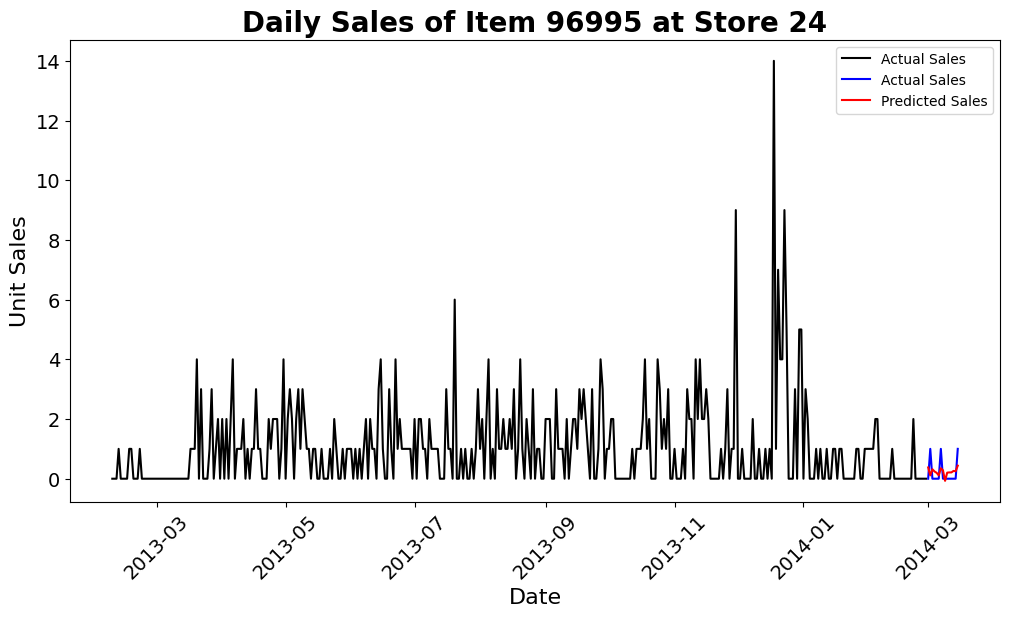

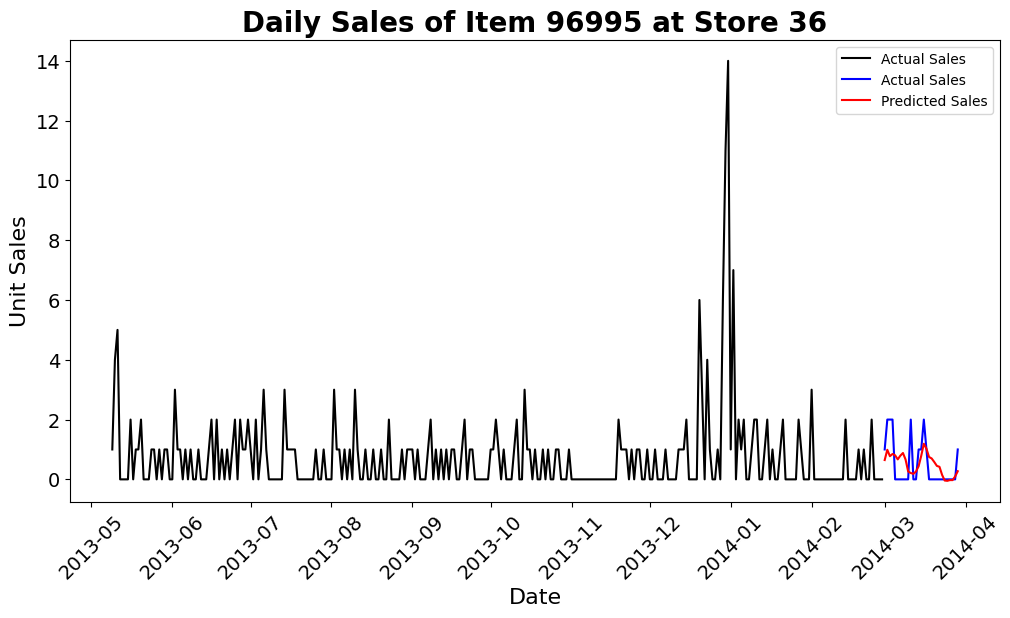

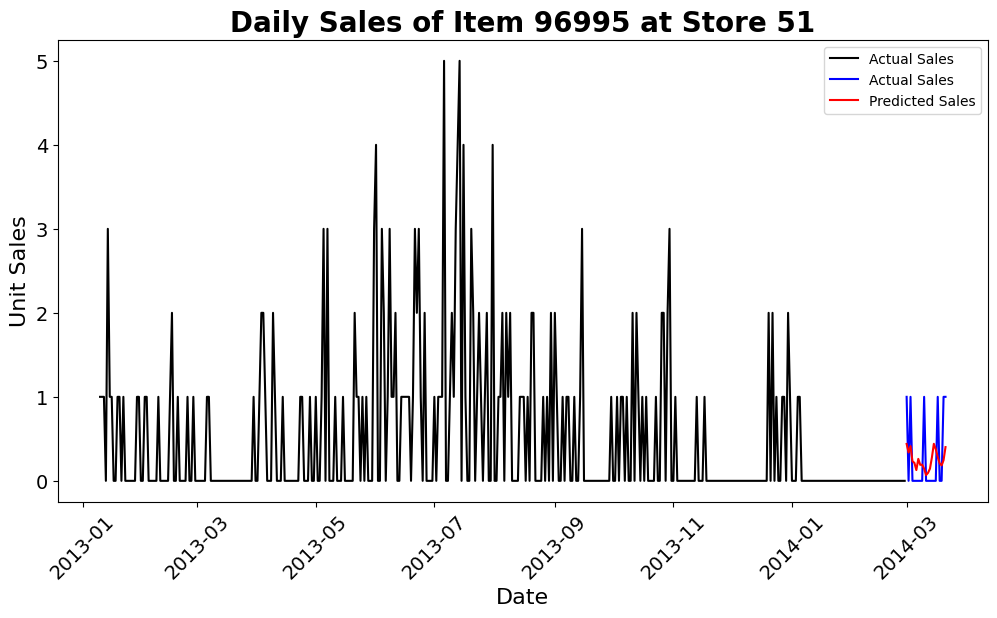

In [ ]:
# Calculate metrics values and Plot the actual vs predicted values
rmad_values = []
bias_values = []
rmse_values = []
plot_paths = []
plot_count  = 0
for (item_nbr, store_nbr), group in df_filled.groupby(['item_nbr', 'store_nbr']):
  #group = group.groupby(['date']).sum()['unit_sales'].reset_index()
  test_series = group[group['date'] >= split_date]
  if(len(test_series)>10):
    X_test = test_series.drop('unit_sales', axis=1)
    X_test = X_test.drop('date', axis=1)
    y_test = test_series['unit_sales']
    # Make predictions on the test set
    y_pred = xgboost_model.predict(X_test)

    if plot_count<3:
      train_series = group[group['date'] < split_date]
      plt.figure(figsize=(12, 6))
      plt.plot(train_series['date'], train_series['unit_sales'].values, label='Actual Sales', color='black')
      plt.plot(test_series['date'], y_test.values, label='Actual Sales', color='blue')
      plt.plot(test_series['date'], y_pred, label='Predicted Sales', color='red')
      plt.title(f'Daily Sales of Item {item_nbr} at Store {store_nbr}', fontsize=20, fontweight='bold')
      plt.xlabel('Date', fontsize=16)
      plt.ylabel('Unit Sales', fontsize=16)
      plt.xticks(fontsize=14, rotation=45)
      plt.yticks(fontsize=14)
      file_path = f'XGBoost_forecast_store_{store_nbr}_item_{item_nbr}.png'
      plt.legend()
      plt.savefig(file_path)  # Saves the plot as a PNG file
      plt.show()
      plot_paths.append(file_path)
      plot_count = plot_count + 1

    #Calculate metric values for XGBoost model
    # Bias calculation: mean of the residuals (y_pred - y_test)
    bias = np.mean(y_pred - y_test)
    bias_values.append(bias)
    # Root Mean Absolute Deviation (RMAD)
    rmad = np.mean(np.abs(y_pred - y_test))
    rmad_values.append(rmad)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

## Log metrics for XGBoost model in MLFlow

In [ ]:
import mlflow.xgboost
with mlflow.start_run(run_name="XGBoost_store_item_features_run"):
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")
    mlflow.log_param("objective", "reg:squarederror") #value we used above
    mlflow.log_param("n_estimators", 50) #value we used above
    mlflow.log_param("max_depth", 5) #value we used above
    mlflow.log_param("learning_rate", 0.2) #value we used above
    mlflow.log_metric("rMAD", sum(rmad_values)/len(rmad_values)) #average rMAD
    mlflow.log_metric("Bias", sum(bias_values)/len(bias_values)) #average Bias
    mlflow.log_metric("RMSE", sum(rmse_values)/len(rmse_values)) #average RMSE
    for plot_path in plot_paths:
      mlflow.log_artifact(plot_path, artifact_path="plots")
    # Log the XGBoost model
    ## Example data (replace with a sample from your dataset)
    #input_example = X_train[:5]
    # Infer signature from input and output data
    signature = infer_signature(X_train, xgboost_model.predict(X_train))
    #print(signature)
    #mlflow.sklearn.log_model(xgboost_model, "xgboost_model",
    #                         signature=signature)
    mlflow.xgboost.log_model(xgboost_model, "xgboost_model",
                             signature=signature)
    # Optionally log parameters, metrics, etc.
    mlflow.log_params(xgboost_model.get_params())
    mlflow.log_metric("train_score", xgboost_model.score(X_train, y_train))

Run ID: 365e946a3f85489a8909a980332c6e07


/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:13:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose bet

# (Optional) save Pickle file with the model in Google Drive
Next week we will create an application with our model. To serve model in the application, we create a pickle file below and next week we will use this file in our app.
Note: you will experiment a lot and create many models. Pickle file you need only for the best model you create this week. To learn more about pickle files, please check the additional material suggested for this week.

In [ ]:
logged_model = 'runs:/a244b4ef00424f7a8dfee6f3a8ddb089/xgboost_model' # you can find run id of your best run in MLFlow UI. See the video in Sprint 4 for more detailed instruction

# Load model as a generic PyFuncModel.
#loaded_model = mlflow.pyfunc.load_model(logged_model)
#input_schema = loaded_model.metadata.get_input_schema()
#print(input_schema)

# Load model as xgboost model
loaded_model = mlflow.xgboost.load_model(logged_model)
print("=== Model type",type(loaded_model))

=== Model type <class 'xgboost.sklearn.XGBRegressor'>


In [ ]:
# create the path to store pickle files of the models
!mkdir /content/drive/MyDrive/models/

In [ ]:
import pickle
# Save the model as a pickle file in Google Drive
pickle_path = '/content/drive/MyDrive/models/xgboost_model.pkl'  # Adjust Google Drive path as desired

with open(pickle_path, 'wb') as f:
    pickle.dump(loaded_model, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /content/drive/MyDrive/models/xgboost_model.pkl
